In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import seaborn as sns
import optuna
import warnings
import re
from scipy.stats import gamma
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
from tensorflow import feature_column
import math

In [2]:
train = pd.read_csv(r'/Users/Henry/Downloads/CSVswithJanuaryJuly/TrainwithJanuaryJuly.csv', index_col='patient_id')
test = pd.read_csv(r'/Users/Henry/Downloads/CSVswithJanuaryJuly/TestwithJanuaryJuly.csv', index_col='patient_id')
print(train.shape)

(13173, 81)


In [3]:
print(test.shape)

(5646, 80)


In [4]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='purple')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_zip3,int64,13173,751,5.701055,0,0.000000,568.530859,275.758485,100.000000,330.000000,557.000000,832.000000,995.000000
patient_age,int64,13173,67,0.508616,0,0.000000,59.271313,13.218883,18.000000,50.000000,59.000000,67.000000,91.000000
metastatic_diagnosis_period,int64,13173,366,2.778410,0,0.000000,96.515221,108.969873,0.000000,3.000000,44.000000,181.000000,365.000000
population,float64,13173,751,5.701055,0,0.000000,20651.373928,13840.379638,635.550000,9160.340000,18952.780000,30021.280000,71374.130000
density,float64,13173,747,5.670690,0,0.000000,1776.872376,3876.061897,0.920000,163.150000,700.340000,1666.520000,29851.690000
age_median,float64,13173,594,4.509223,0,0.000000,40.542676,4.031027,20.600000,37.190000,40.640000,42.940000,54.570000
age_under_10,float64,13173,450,3.416078,0,0.000000,11.104988,1.511534,0.000000,10.150000,11.000000,12.140000,17.680000
age_10_to_19,float64,13173,472,3.583087,0,0.000000,12.857587,1.952248,6.310000,11.650000,12.900000,13.910000,35.300000
age_20s,float64,13173,519,3.939877,0,0.000000,13.297375,3.390472,5.930000,11.000000,12.530000,14.970000,62.100000
age_30s,float64,13173,457,3.469217,0,0.000000,12.893557,2.410845,1.500000,11.270000,12.400000,14.130000,25.470000


In [5]:
desc = pd.DataFrame(index = list(test))
desc['type'] = test.dtypes
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] /len(test) * 100
desc['null'] = test.isnull().sum()
desc['%null'] = desc['null'] / len(test) * 100
desc = pd.concat([desc,test.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='purple')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_zip3,int64,5646,669,11.849097,0,0.000000,569.824655,276.824893,100.000000,330.000000,554.000000,836.000000,997.000000
patient_age,int64,5646,67,1.186681,0,0.000000,58.921537,13.326813,18.000000,50.000000,59.000000,66.000000,91.000000
population,float64,5646,669,11.849097,0,0.000000,20865.277040,14252.666477,829.520000,8893.480000,19154.190000,30145.890000,71374.130000
density,float64,5646,667,11.813673,0,0.000000,1826.421314,3928.358993,0.920000,161.930000,688.010000,1686.320000,29851.690000
age_median,float64,5646,536,9.493447,0,0.000000,40.509499,3.983375,30.030000,37.130000,40.640000,42.940000,54.570000
age_under_10,float64,5646,425,7.527453,0,0.000000,11.123819,1.498752,5.220000,10.150000,11.040000,12.190000,17.680000
age_10_to_19,float64,5646,433,7.669146,0,0.000000,12.868130,1.906942,6.310000,11.680000,12.920000,13.890000,24.900000
age_20s,float64,5646,476,8.430747,0,0.000000,13.291959,3.226722,5.930000,11.020000,12.540000,14.970000,36.900000
age_30s,float64,5646,428,7.580588,0,0.000000,12.902175,2.395298,5.690000,11.270000,12.420000,14.150000,25.470000
age_40s,float64,5646,383,6.783564,0,0.000000,12.050205,1.216250,7.060000,11.340000,12.090000,12.840000,17.820000


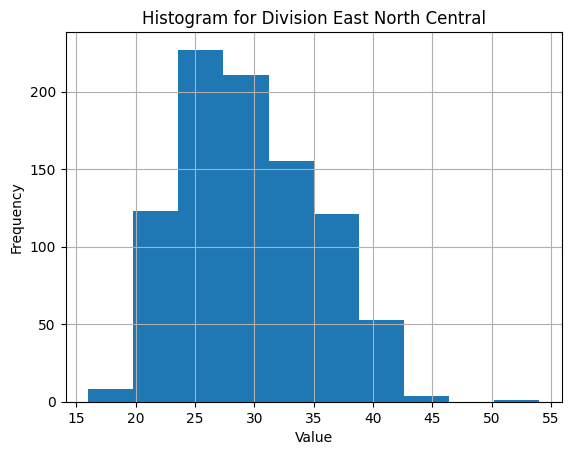

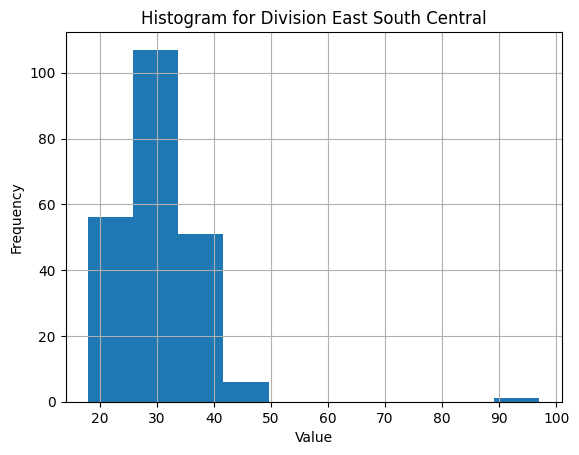

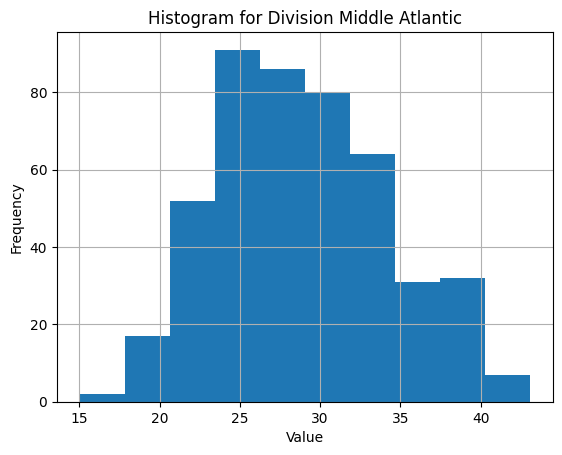

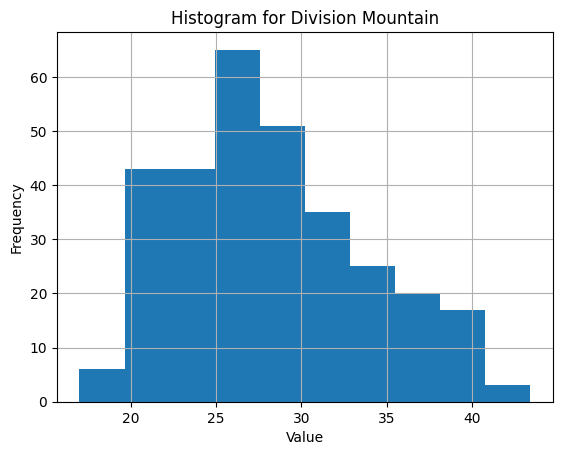

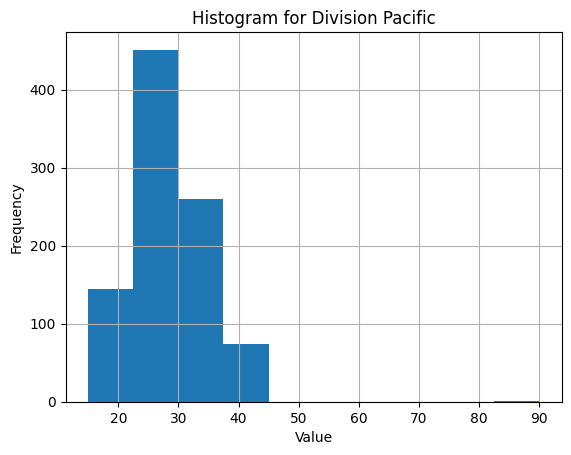

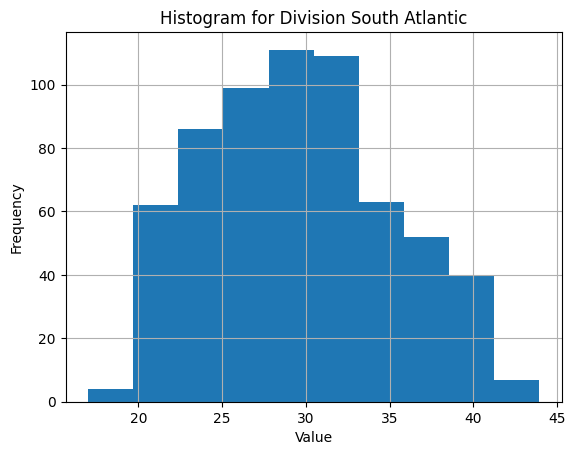

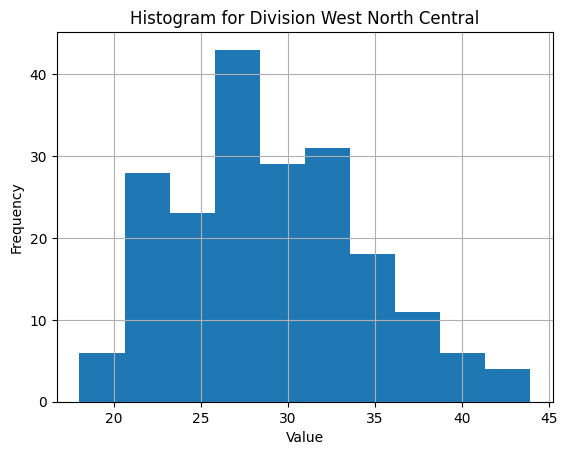

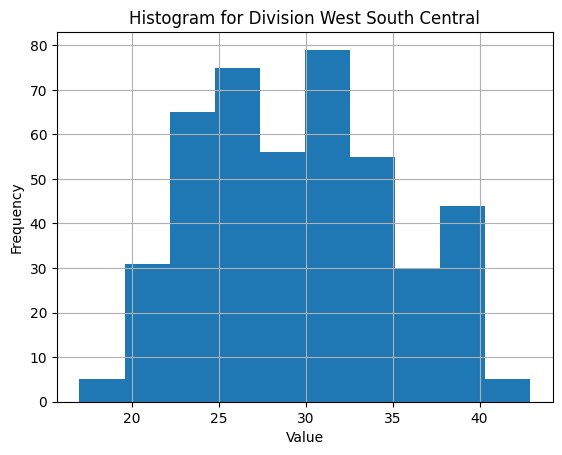

In [6]:
train_nonullbmi = train.copy()
train_nonullbmi.dropna(subset=['bmi'], inplace=True)
grouped_data = train_nonullbmi.groupby('Division')

# Iterate over each group (unique zipcode) and plot a histogram
for division, group in grouped_data:
    plt.figure()  # Create a new figure for each histogram
    group['bmi'].hist()
    plt.title(f'Histogram for Division {division}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

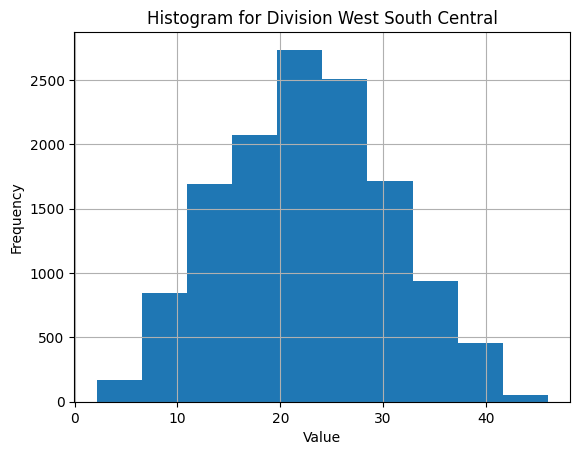

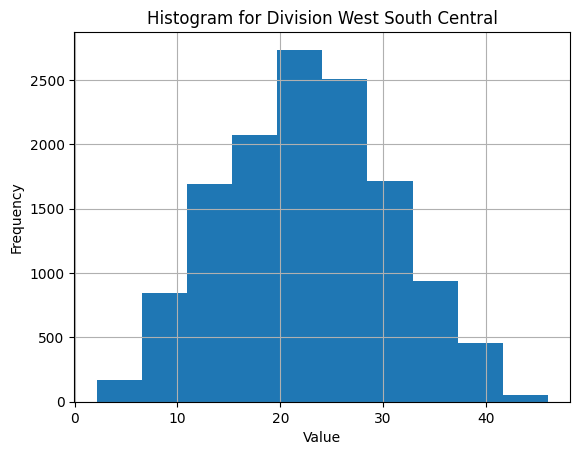

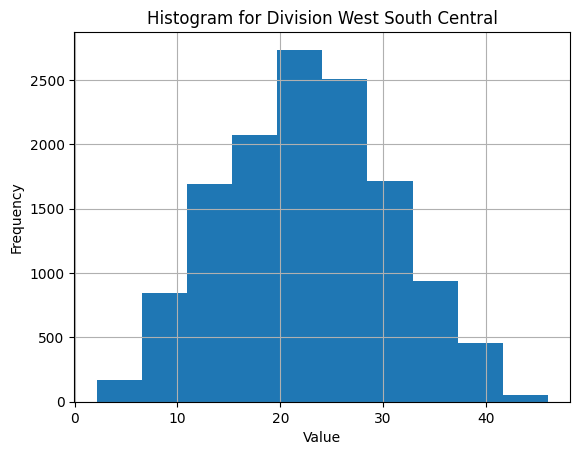

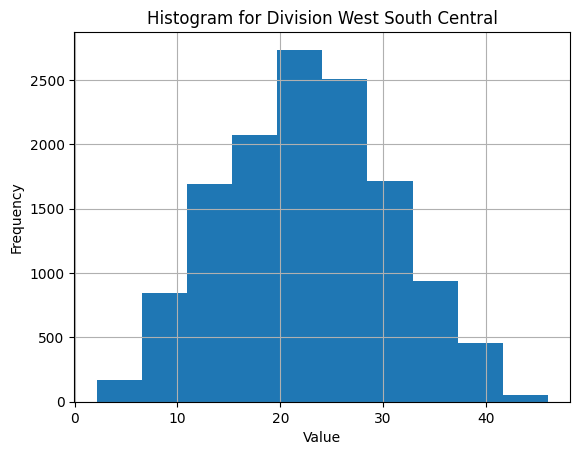

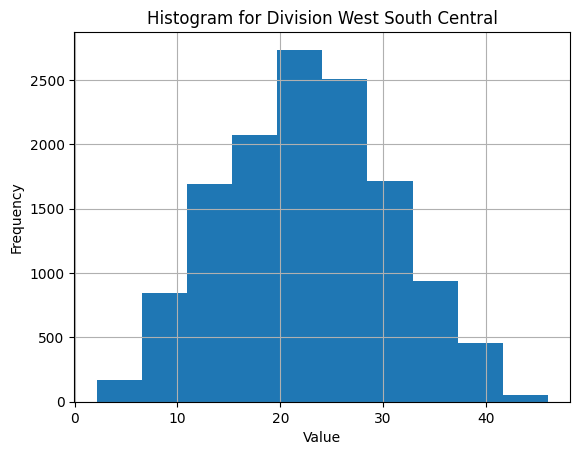

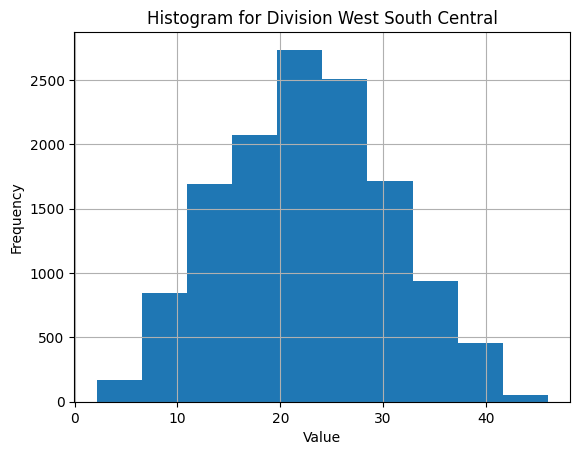

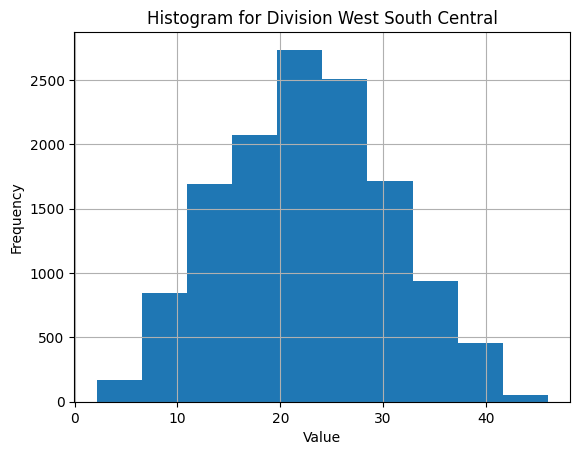

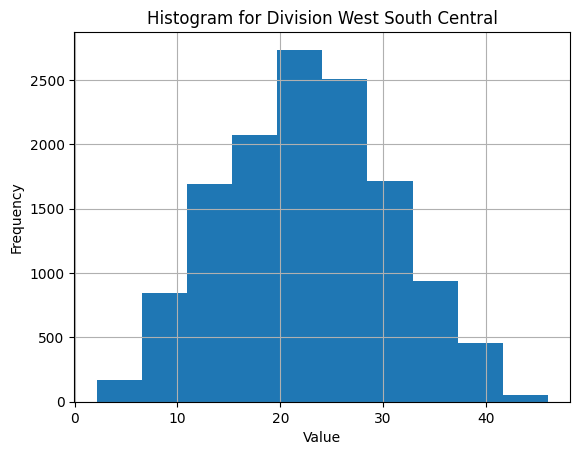

In [7]:
train_eastnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East North Central"]
train_eastsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East South Central"]
train_middleatlantic = train_nonullbmi[train_nonullbmi["Division"]=="Middle Atlantic"]
train_mountain = train_nonullbmi[train_nonullbmi["Division"]=="Mountain"]
train_pacific = train_nonullbmi[train_nonullbmi["Division"]=="Pacific"]
train_southatlantic = train_nonullbmi[train_nonullbmi["Division"]=="South Atlantic"]
train_westnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West North Central"]
train_westsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West South Central"]


train_bmimask = train["bmi"].isnull()

modeled = pd.DataFrame()

grouped_data_train = train.groupby('Division')          
for division, trainingroup in grouped_data_train:
    division_word = division
    division = division.replace(" ", "")
    division = division.lower()
    variable = f'train_{division}'
    shape, loc, scale = gamma.fit(locals()[variable]['bmi'])
    training = train.loc[train_bmimask]
    training.loc[train["Division"] == f"{division_word}", "bmi"] = np.random.gamma(shape=shape, scale=scale, size=len(training.loc[train["Division"] == f"{division_word}", "bmi"]))
    modeled = pd.concat([training, modeled])

train = pd.concat([modeled, train_nonullbmi])
train = train[train['bmi']<50]
grouped_data_train = train.groupby('Division')          
for division, trainingroup in grouped_data_train:    
    plt.figure()  # Create a new figure for each histogram
    train['bmi'].hist()
    plt.title(f'Histogram for Division {division_word}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

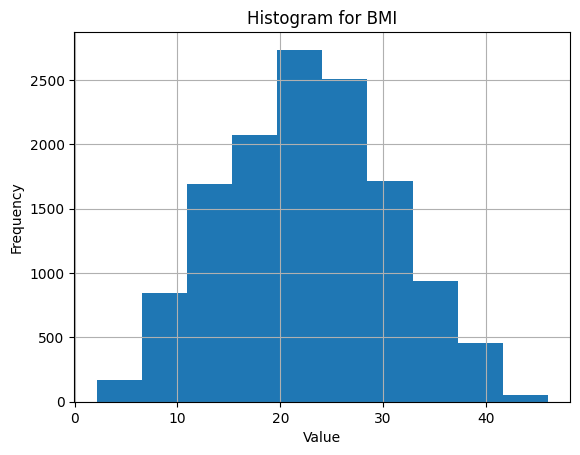

In [8]:
plt.figure()  # Create a new figure for each histogram
train['bmi'].hist()
plt.title(f'Histogram for BMI')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

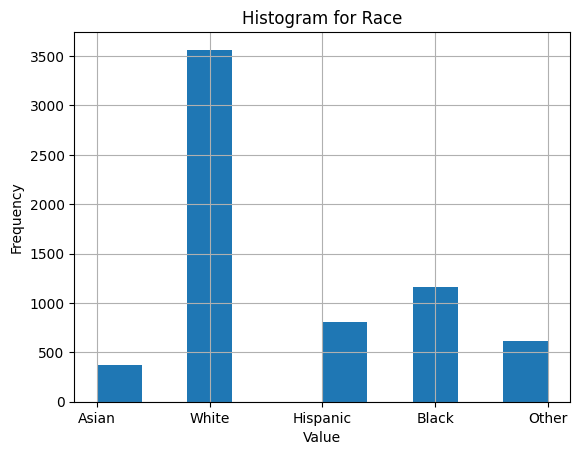

In [9]:
#check current distribution of race without the null values

train_nonullrace = train.copy()
train_nonullrace.dropna(subset=['patient_race'], inplace=True)
plt.figure()  # Create a new figure for each histogram
train_nonullrace['patient_race'].hist()
plt.title('Histogram for Race')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Replace patient_race null values in train randomly, based on the current distribution of patient_race

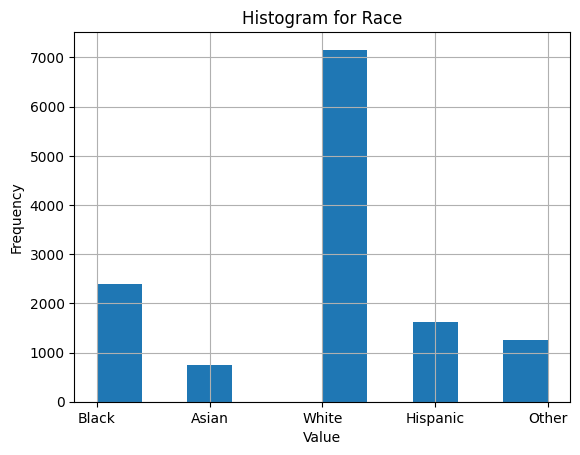

In [10]:
distribution = train_nonullrace['patient_race'].value_counts(normalize=True)
def fill_nulls_with_random_categories(row):
    if pd.isnull(row['patient_race']):
        return np.random.choice(distribution.index, p=distribution.values)
    else:
        return row['patient_race']
train['patient_race'] = train.apply(fill_nulls_with_random_categories, axis=1)

plt.figure()  # Create a new figure for each histogram
train['patient_race'].hist()
plt.title('Histogram for Race')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Turn each categorical variable into binary columns for each option in the Train dataset

In [11]:
one_hot_encoder_race = LabelBinarizer()
one_hot_encoder_race.fit(train['patient_race'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedrace = pd.DataFrame(one_hot_encoder_race.transform(train['patient_race']),columns=one_hot_encoder_race.classes_, index=train.index)
#Combine with original data frame
train = pd.concat([train,transformedrace], axis = 1)

one_hot_encoder_division = LabelBinarizer()
one_hot_encoder_division.fit(train['Division'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformeddivision = pd.DataFrame(one_hot_encoder_division.transform(train['Division']),columns=one_hot_encoder_division.classes_, index=train.index)
#Combine with original data frame
train = pd.concat([train,transformeddivision], axis = 1)

one_hot_encoder_region = LabelBinarizer()
one_hot_encoder_region.fit(train['Region'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedregion = pd.DataFrame(one_hot_encoder_region.transform(train['Region']),columns=one_hot_encoder_region.classes_, index=train.index)
#Combine with original data frame
train = pd.concat([train,transformedregion], axis = 1)

one_hot_encoder_state = LabelBinarizer()
one_hot_encoder_state.fit(train['patient_state'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedstate = pd.DataFrame(one_hot_encoder_state.transform(train['patient_state']),columns=one_hot_encoder_state.classes_, index=train.index)
#Combine with original data frame
train = pd.concat([train,transformedstate], axis = 1)

# Build a model using Train data after dropping categorical and irrelavent columns

In [12]:
y = train['metastatic_diagnosis_period']
print(train.shape)
columns_to_drop = ['metastatic_diagnosis_period', 
                   'metastatic_first_novel_treatment_type', 
                   'metastatic_first_novel_treatment', 
                   'payer_type', 
                   'patient_race', 
                   'patient_gender', 
                   'Region', 
                   'Division', 
                   'patient_state',
                   'metastatic_cancer_diagnosis_code',
                   'breast_cancer_diagnosis_desc',
                   'breast_cancer_diagnosis_code'
                  ]
x = train.drop(columns=columns_to_drop, axis=1)
x = x.dropna()
print(x.shape)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x.shape[1],)),  # Input shape based on number of features
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])
model.compile(optimizer='adam',
              loss='mse',  # Mean Squared Error for regression task
              metrics=['mae'])  # Mean Absolute Error for evaluation
model.fit(x, y, epochs=10, batch_size=32, validation_split=0.2)

(13170, 142)
(13165, 130)
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 117850856.0000 - mae: 4806.4619 - val_loss: 107957.0469 - val_mae: 225.1337
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 63867.1797 - mae: 178.0876 - val_loss: 53714.1133 - val_mae: 171.9520
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 36703.0156 - mae: 146.5427 - val_loss: 58379.9336 - val_mae: 191.7325
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 38596.1914 - mae: 149.6960 - val_loss: 23164.7246 - val_mae: 116.5942
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 28686.0840 - mae: 130.5947 - val_loss: 22346.2871 - val_mae: 118.0672
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 26651.1973 - mae: 126.0597 - val_loss: 21838.4570 - val_mae: 122.0706
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 20681.9648 - mae: 114.5043 - val_loss: 16171.1689 - val_mae: 105.6630
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 25102.0352 - mae: 1

In [13]:
test_nonullrace = test.copy()
test_nonullrace.dropna(subset=['patient_race'], inplace=True)
distribution = test_nonullrace['patient_race'].value_counts(normalize=True)
test['patient_race'] = test.apply(fill_nulls_with_random_categories, axis=1)


one_hot_encoder_race_test = LabelBinarizer()
one_hot_encoder_race_test.fit(test['patient_race'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedracetest = pd.DataFrame(one_hot_encoder_race_test.transform(test['patient_race']),columns=one_hot_encoder_race_test.classes_, index=test.index)
#Combine with original data frame
test = pd.concat([test,transformedracetest], axis = 1)

one_hot_encoder_division_test = LabelBinarizer()
one_hot_encoder_division_test.fit(test['Division'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformeddivisiontest = pd.DataFrame(one_hot_encoder_division_test.transform(test['Division']),columns=one_hot_encoder_division_test.classes_, index=test.index)
#Combine with original data frame
test = pd.concat([test,transformeddivisiontest], axis = 1)

one_hot_encoder_region_test = LabelBinarizer()
one_hot_encoder_region_test.fit(test['Region'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedregiontest = pd.DataFrame(one_hot_encoder_region_test.transform(test['Region']),columns=one_hot_encoder_region_test.classes_, index=test.index)
#Combine with original data frame
test = pd.concat([test,transformedregiontest], axis = 1)

one_hot_encoder_state_test = LabelBinarizer()
one_hot_encoder_state_test.fit(test['patient_state'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformedstatetest = pd.DataFrame(one_hot_encoder_state_test.transform(test['patient_state']),columns=one_hot_encoder_state_test.classes_, index=test.index)
#Combine with original data frame
test = pd.concat([test,transformedstatetest], axis = 1)

In [14]:
columns_to_drop2 = ['metastatic_first_novel_treatment_type', 
                   'metastatic_first_novel_treatment', 
                   'payer_type', 
                   'patient_race', 
                   'patient_gender', 
                   'Region', 
                   'Division', 
                   'patient_state',
                   'metastatic_cancer_diagnosis_code',
                   'breast_cancer_diagnosis_desc',
                   'breast_cancer_diagnosis_code'
                  ]

x_test = test.drop(columns = columns_to_drop2, axis=1)

predictions = model.predict(x_test)
flat_list = [item for sublist in predictions.tolist() for item in sublist]
data = {'patient_id': test.index,
        'metastatic_diagnosis_period': flat_list}
df = pd.DataFrame(data)
df.to_csv('solutions.csv', index=False)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
